# Correlation Exercise – *Galileo E1‑C*

This interactive notebook guides you through the **coarse‑acquisition** step used by every GNSS receiver.  You’ll fill in the missing pieces, run the code, and **acquire a real satellite you recorded**.

## How to work in this notebook
1. **Read the short theory sections**  They recap what the code does. Also recall the presentation slides.
2. **Open each *Task* cell (yellow bar on the left) and replace the `...` with real code or numbers.**  Run the cell *(Shift‑Enter)*.
3. **Run the script cell that follows.**  If something is still missing the script will stop and tell you what.
4. Move on to the next section.

>👉 **Tip 1:** execute the notebook **top‑to‑bottom** the first time so that all variables are visible where the scripts expect them.
>
>👉 **Tip 2:** *Click regularly on the "save to browser storage button" (next to the download button) to not lose your progress.*

# 0. IQ Data and Pre-Processing
This section demonstrates how to transform raw **I/Q** recordings into a cleaned MATLAB `.mat` file that later acquisition steps can load.

**You will:**
1. Set the sampling frequency and file path  
2. Read the binary file, format the complex samples  
3. Inspect spectrum, time‑domain traces and amplitude histogram  
4. Save the processed vector as **`IQ_samples.mat`**

Follow the numbered code cells below and execute them in order (⇧ + ⏎).

### 1.  Set Sampling Frequency

In [1]:
% Sampling frequency (Hz)
fs = 2.046e6;  % Enter sampling frequency, e.g. 1.000e6 for 1 MHz

### 2.  Set Data File Path

In [2]:
% Path to I/Q data file
data_file = 'IQ_samples_CA.dat';  % ← Enter filename, e.g. 'IQ.dat'

### 3.  Load and Format I/Q Samples
Read the binary file, handle interleaved I/Q channels, and remove initial transients.

In [3]:
% === Fixed Parameters ===
fi = 0;                   % Intermediate frequency (Hz)
IsComplex = true;         % True if data is I/Q
Is8Bits = false;          % 8-bit integer format
Is16Bits = false;         % 16-bit integer format
Is32BitsFloat = true;     % 32-bit float format
secondOfData = 1;         % Seconds of data to read
fl1 = 1575.42e6;          % Center frequency (Hz) for labels
% ========================

% Read binary samples
[fid, errmsg] = fopen(data_file, 'rb');     % binary read

if fid == -1
    fprintf(2, '❌  Unable to open "%s": %s\n', data_file, errmsg);
    return              % Abort this cell early
end
if IsComplex
    if Is16Bits
        [raw, ~] = fread(fid, 2*secondOfData*fs, 'int16');
    elseif Is8Bits
        [raw, ~] = fread(fid, 2*secondOfData*fs, 'int8');
    else
        [raw, ~] = fread(fid, 2*secondOfData*fs, 'float32');
    end
    data = raw(1:2:end) + 1i*raw(2:2:end);
else
    if Is16Bits
        [data, ~] = fread(fid, secondOfData*fs, 'int16');
    elseif Is8Bits
        [data, ~] = fread(fid, secondOfData*fs, 'int8');
    else
        [data, ~] = fread(fid, secondOfData*fs, 'float32');
    end
end
fclose(fid);

% Remove initial transient samples
if length(data) > 1e6
    data(1:1e6) = [];
end

### 4.  Power Spectral Density
Use Welch's method to estimate PSD and plot it. Frequency axis is in MHz.
https://en.wikipedia.org/wiki/Welch%27s_method 

➡️  [PSD]  Starting Welch PSD estimate …
   ✓  Loaded Octave-Forge package: signal
   ✓  PSD computed with pwelch()


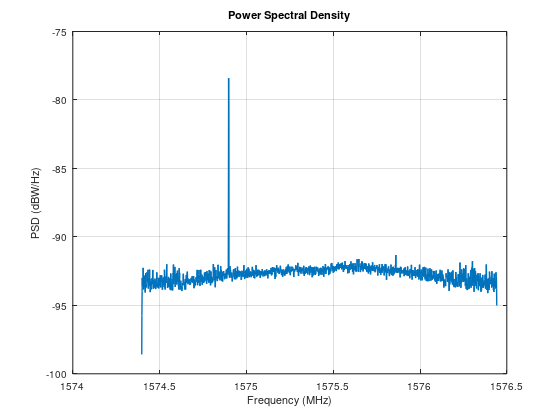

✅  [PSD]  Finished and plotted.


In [4]:
disp("➡️  [PSD]  Starting Welch PSD estimate …");

% ------------------------------------------------------------
% 1. Make sure the Octave-Forge “signal” package is available
% ------------------------------------------------------------
has_signal = false;
try
    % does "signal" appear in the installed-package list?
    pkgs = pkg("list");
    for k = 1 : numel(pkgs)
        if strcmp(pkgs{k}.name, "signal")
            has_signal = true;
            break
        end
    end
catch
    % pkg() itself not found (rare)
end

if has_signal
    try
        pkg load signal
        disp("   ✓  Loaded Octave-Forge package: signal");
    catch ME
        has_signal = false;
        fprintf(2,"   ⚠️  Could not load 'signal' package (%s). Falling back to naive PSD.\n", ME.message);
    end
else
    fprintf(2,"   ⚠️  Package 'signal' not installed. Falling back to naive PSD.\n");
end

% ------------------------------------------------------------
% 2. Compute PSD
% ------------------------------------------------------------
if has_signal
    [pw, f] = pwelch(data, [], [], [], fs);    % Welch method
    disp("   ✓  PSD computed with pwelch()");
else
    % --- simple rectangular window periodogram as a fallback ---
    Nfft  = 4096;
    win   = hanning(Nfft);                     % a little windowing to reduce leakage
    S     = fftshift( fft( data(1:Nfft) .* win.' , Nfft ) );
    pw    = (abs(S).^2) / (fs * sum(win.^2));
    f     = linspace(-fs/2, fs/2, Nfft);
    disp("   ✓  PSD computed with naive FFT method");
end

% ------------------------------------------------------------
% 3. Plot
% ------------------------------------------------------------
figure;
if IsComplex
    plot((f + fl1 - fs/2)/1e6, 10*log10(pw), 'LineWidth', 1);
else
    plot(f/1e6,          10*log10(pw), 'LineWidth', 1);
end
grid on;
xlabel('Frequency (MHz)');
ylabel('PSD (dBW/Hz)');
title('Power Spectral Density');

disp("✅  [PSD]  Finished and plotted.");


### 5.  Time‑Domain View
Visualize the first 100,000 samples of the real and imaginary parts.

➡️  [TD]  Plotting real & imaginary parts …
   ✓  Using first 100000 samples for the snapshot.


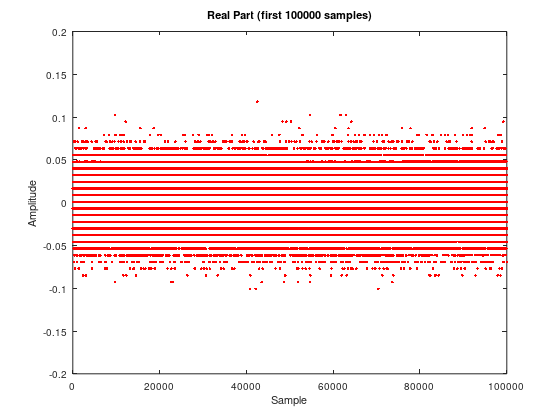

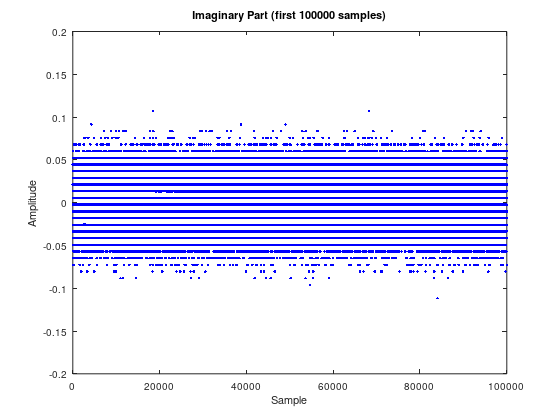

✅  [TD]  Finished plotting time-domain snapshots.


In [5]:
disp("➡️  [TD]  Plotting real & imaginary parts …");

% ------------------------------------------------------------
% 1. Decide how many samples we can safely show
% ------------------------------------------------------------
if numel(data) < 1e5
    nplot = numel(data);
    fprintf(2, "   ⚠️  Only %d samples available – plotting all of them.\n", nplot);
else
    nplot = 1e5;
    fprintf("   ✓  Using first %d samples for the snapshot.\n", nplot);
end

% ------------------------------------------------------------
% 2. Real component
% ------------------------------------------------------------
figure;
plot(real(data(1:nplot)), 'r.');
xlabel('Sample');  ylabel('Amplitude');
title(sprintf('Real Part (first %d samples)', nplot));

% ------------------------------------------------------------
% 3. Imaginary component
% ------------------------------------------------------------
figure;
plot(imag(data(1:nplot)), 'b.');
xlabel('Sample');  ylabel('Amplitude');
title(sprintf('Imaginary Part (first %d samples)', nplot));

disp("✅  [TD]  Finished plotting time-domain snapshots.");


### 6. Histogram of Real Component
Plot the amplitude distribution to check for clipping or quantization.

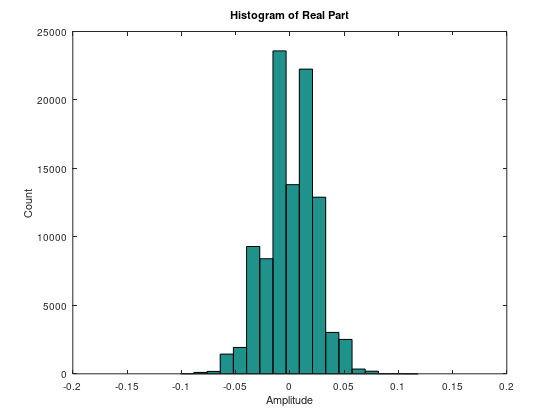

In [6]:
figure;
hist(real(data(1:1e5)), 18);
xlabel('Amplitude');
ylabel('Count');
title('Histogram of Real Part');

### 7.  Save Processed Data

In [7]:
% Save to MAT-file
save('IQ_samples.mat', 'data');
disp('✅ Data saved to IQ_samples.mat');
disp('✅ Check in the left sidebar, you should find the .mat file there');

✅ Data saved to IQ_samples.mat
✅ Check in the left sidebar, you should find the .mat file there


# 1. Common Helper Functions

Below are the three MATLAB/Octave functions that every GNSS acquisition routine needs.

* **`CodeAcquisition`** – builds a 2‑D delay/Doppler search space using an FFT‑based correlation technique.
* **`NoiseVarianceEstimator`** – estimate of the noise floor .
* **`InverseChiSquarePfa`** – finds the chi-square threshold (Th) such that its upper-tail probability equals the target false alarm probability (PfaT).

🔍 ***Where you still need to work*** – The first function contains *TODO* markers so you can practise the maths behind the FFT acquisition.

### ✍️ **`CodeAcquisition`**  *Complete me!*
This routine builds a 2-D “delay vs. Doppler” map by doing a matched-filter correlation in the frequency domain:

1. **Normalize frequencies**
   Convert the IF (`fi`) and Doppler offsets into fractions of the sampling rate so everything works in normalized units.

2. **Prepare the replica filter**
   Compute `F_rep = __________?` once – this is your matched filter for the local code sequence.

3. **Loop over Doppler bins**
   For each Doppler hypothesis, mix the incoming signal down by `exp(–2jπ·freq·t)`, FFT it, multiply by `F_rep` (i.e. correlate), then IFFT back to get correlation vs. code delay.

4. **Form the detection metric**
   Take the magnitude-squared of each complex correlation to fill out the final `sspace` matrix, which you can then search for peaks.
5. **Your Task** : Fill in the missing line 26 to compute the frequency-domain matched filter for the code replica.
    > *Hint: Use the FFT and complex conjugate of the replica*


In [8]:
function sspace = CodeAcquisition(signal, rep, Nc, Doppler_vec, fs, fi)
% CodeAcquisition  Evaluate the search space for code acquisition using
%                  a time-domain FFT technique
%
% Syntax:
%   sspace = CodeAcquisition(signal, rep, Nc, Doppler_vec, fs, fi)
%
% Inputs:
%   signal      [1×N]     Galileo/GPS input signal (with Doppler shift,
%                         code delay, noise, etc.)
%   rep         [1×Nc]    Local code replica
%   Nc          integer   Length of the local code replica
%   Doppler_vec [1×M]     Vector of Doppler offsets (Hz)
%   fs          scalar    Sampling frequency (Hz)
%   fi          scalar    Intermediate frequency (Hz)
%
% Output:
%   sspace      [M×N]     Search-space matrix (correlation magnitudes)

    % Normalize frequencies
    fif           = fi / fs;
    Doppler_norm  = Doppler_vec / fs;

    % TODO
    % Precompute FFT of the local replica
    F_rep = conj(fft(rep));

    % Time index vector
    N = size(signal, 2);
    t = 0:(N - 1);

    % Allocate output
    sspace = zeros(length(Doppler_norm), N);

    % Loop over all Doppler bins
    for i = 1:length(Doppler_norm)
        fc    = fif + Doppler_norm(i);
        % Mix the input down to baseband for this Doppler bin
        IQ    = exp(-2j * pi * fc .* t) .* signal;
        % FFT of the mixed signal
        X     = fft(IQ);
        % Frequency-domain correlation via multiplication
        sspace(i, :) = ifft(X .* F_rep);
    end

    % Convert to real magnitude-squared values
    sspace = real(sspace .* conj(sspace));
end

### ▶ **`NoiseVarianceEstimator`**
This function estimates the noise variance in `y` by:

1. **Random code**
   Create a bipolar (±1) sequence whose length matches the data duration (`clen`).

2. **Upsample**
   Stretch that code to the full sampling rate (`fs`) so it aligns with `y`.

3. **Correlate**
   Run one Doppler‐free correlation of `y` against this “noise” code via `CodeAcquisition`.

4. **Decimate**
   Pick every `fs/fc`-th correlator output to obtain roughly independent noise samples.

5. **Compute variance**
   Take the mean of those samples and divide by 2 → your noise‐variance estimate `sigma_est`.

In [9]:
function sigma_est = NoiseVarianceEstimator( y, fs, fc )

% Arguments:
%   y :         [vector] contains the input samples
%   fs:         [scalar] sampling frequency
%   fc:         [scalar] code rate

%
% Returns:
%   sigma_est:     [scalar] the estimated noise variance
%%

% First generate a fictitious code
clen = round( length( y ) / fs * fc );
code =  sign( rand( 1, clen ) - 0.5 );      % A bipolar random code usually has
                                            % good correlation properties

% Resample the code
loc = reshape(repmat(code,fs/fc,1),1,fs/fc*size(code,2));

% Now compute the correlators (for a single Doppler value is enough )
correlators = CodeAcquisition( y, loc, 1, 0, fs, 0 );


% Down-sample them to get uncorrelated values:
step = round( fs / fc );
correlators = correlators(1:step:end);

% Finally the noise variance estimate
sigma_est = mean( correlators ) / 2;


### ▶ **`InverseChiSquarePfa`**
This routine finds the χ²–distribution threshold `Th` for `K` degrees of freedom that yields a target false‐alarm rate `PfaT`.

In [10]:
function Th = InverseChiSquarePfa( K, PfaT )

Th = -2*log( PfaT );

Niter = 1000;
Pfa = 0;
ii = 1;

fact = factorial( K - 1 );

while abs( PfaT - Pfa ) > 1e-3 * PfaT,

    Pfa = gammainc( Th / 2, K, 'upper' );					% Compute the ccdf
    pdf = exp( -Th / 2 ) .* ( Th / 2 ).^( K - 1 ) / fact;	% Compute the pdf

    Th = Th + ( Pfa - PfaT )/ pdf;

    ii = ii + 1;
    if ii > Niter,
        break;
    end
    
end

# 2. Galileo E1‑C acquisition

**Goal:** detect a Galileo E1‑C pilot code in an IQ recording.

The acquisition uses a **BOC(1,1)** modulated replica.

There are two steps for you:
1. *Task&nbsp;G1* – enter the **signal parameters** (chip rate, sample rate, code period, integration time, IF).
2. *Task&nbsp;G2* – build the **BOC sub‑carrier** used to modulate the replica.

After completing both, run the `Acquire Galileo E1C` section immediately below to sweep delay/Doppler space.

### ✍️ Task G1 - *Complete Galileo Signal Parameters* 
Fill in the following Galileo signal parameters. When finished, run the section to initialize the variables.

In [11]:
% % Chip rate  [Hz]
% fc = ;

% % Sample rate [Hz]
% fs = ;

% % Primary‑code period [ms]
% T_primary_code = = ;

% % Coherent integration time [s] (e.g. 0.004)
% Tcoh = =;

% % Intermediate frequency after down‑conversion [Hz]
% fi = =;

Execution exception: parse error near line 2 of file cell[11]

  syntax error

>>> fc = ;
         ^

### ✍️ Task G2 - *Build the BOC sub-carrier* 
The objetive of this task is to produce a vector *boc* with +1/-1 values at the sampling rate *fs* corresponding to one chip (8 samples at 1.023 MHz → 8 samples). Then, tile it so it matches the PRN length used.

**Remember:**

- Galileo E1C is modulated as a BOC(1,1) therefore we need to generate for the replica signal

- You need to overlay (multiply) every PRN code chip with the corresponding BOC spreading symbol

**What you need to do:**

**Step 1:** Generate a single BOC spreading symbol at the correct sample rate. 

> *Hint: considering the ratio of sample rate and chip rate you need to generate a BOC spreading symbol of 8 bits.*

In [ ]:
BOC1_1_subcarrier = ;

**Step 2:** Repeat the generated spreading symbol `BOC1_1_subcarrier` 4092 times to align with the number of chips in the replica that we are using.

In [ ]:
BOC1_1_subcarrier_4ms = ;

**Step 3:** `BOC1_1_subcarrier_4ms` is a vector of size 1 x 4092*8. Now we repeat this vector 50 times (this is the number of PRN sequences we have loaded).

In [ ]:
BOC1_1_subcarrier_4ms = ;

**Step 4:** Now we generate the final replica of all PRN sequences. Do an element by element multiplication of the already existing variable `Rep` by `BOC1_1_subcarrier_4ms` (use for this the operator .* ).

In [ ]:
Rep = ;

In [ ]:

%%% WHAT IS THIS FOR?

% Number of samples in one half-chip:
half_chip_samples = round(fs/(2*fc));

% Number of code chips in one primary code period:
num_chips = round(T_primary_code*1e-3 * fc);

% Build one °ßBOC(1,1)°® chip waveform:
boc_chip = [ones(1, half_chip_samples), -ones(1, half_chip_samples)];

% Tile it to cover the full primary code:
boc = repmat(boc_chip, 1, num_chips);
Rep = Rep .* boc;

### ▶ **`Acquire Galileo E1-C`** *Run after tasks G1 and G2*

In [ ]:
% Sanity checks – stop if you forgot to run the task cells
assert(exist('fc','var') && exist('fs','var') && exist('T_primary_code','var') && exist('Tcoh','var') && exist('fi','var'),...
       '❌ Run Task G1 first and set fc/fs/T_primary_code/Tcoh/fi');
% boc is optional – only needed if you want to overlay it yourself

load IQ_samples.mat

%=========================================================================%
% Load the PRN  code                                                      %
%=========================================================================%

load E1_codes.mat
PRN = E1C;

%=========================================================================%
% Resample the replica                                                    %
%=========================================================================%

N_noncoh = 1; %Number of non-coherent accumulations
Tdwell = Tcoh *N_noncoh; %Total Dwell time [ms]
Nsample = Tcoh * fs; %Number of signal samples in Coherent Integration Period

PRN = repmat(PRN,1,1);

%=========================================================================%
% Build up the replica                                                    %
%=========================================================================%

for i=1:size(PRN,1)

  Rep(i,:) = reshape(repmat(PRN(i,:),fs/fc,1),1,fs/fc*size(PRN,2));
  
end

%=========================================================================%
% Acquisition Process                                                     %
%=========================================================================%

Doppler_range = 6e3 ;
Doppler_step = round(2/(3*Tdwell));
Doppler_vec = Doppler_step:Doppler_step:Doppler_range;
Doppler_vec = [-fliplr(Doppler_vec) 0 Doppler_vec];


%=========================================================================%
% Search over all possible PRN sequences                                  %
%=========================================================================%

for code_select = 10:10
    Rep_search = Rep(code_select,:);
    
    Nc = round(Tcoh/1e-3)*fs/1e3;
    sspace = 0;
    
    for ii = 1:N_noncoh
    
        y =  data( (ii - 1) * Nc + (1:2*Nc) ).';   % use just 1 period of signal at the time
    
        % Compute the search space for a single coherent integration epoch
        Tsspace = CodeAcquisition( y, [Rep_search zeros(1,size(Rep_search,2))], Nc, Doppler_vec, fs, fi);
        sspace = sspace + Tsspace;  % Non-coherently accumulate the results
    
    end
    
    %=========================================================================%
    % Decision Logic                                                          %
    %=========================================================================%
    
    Pfa_global = 0.1;
    Pfa_cell = 1-(1-Pfa_global).^(1/numel(sspace));
    
    Th = InverseChiSquarePfa(N_noncoh, Pfa_cell);
    sigma_est = NoiseVarianceEstimator(y, fs, fc);
    Th = sigma_est * Th;
    
    ##sspace_single_period = reshape(sspace,[size(sspace,1),2*fs/fc*size(PRN,2)/(Tcoh*1e3),2*Tcoh*1e3]);
    ##sspace_single_period = squeeze(sum(sspace_single_period,3));
    
    
    if (max(max(sspace)) > Th)
    
        [doppler_id, delay_id] = find(sspace == max(max(sspace)));
        fprintf('PRN %i acquired, Doppler [Hz]: %f, Code Delay [samples]: %i\n',code_select, Doppler_vec(doppler_id(1)), delay_id(1));
        figure
        surf( sspace, 'EdgeColor', 'none');
        set( gca, 'FontSize', 16)
        xlabel('Delay [samples]');
        ylabel('Doppler Bin');
        xlim([0 size(sspace,2)]);
        ylim([1 length(Doppler_vec)])
    
    end
    

end